In [411]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import plotnine as pl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE, ADASYN
import sklearn.metrics as sm
import copy as cp
from IPython.display import Image

## Reading and cleaning data for future use

In [252]:
#reading the patient info csv file
PatientInfo = pd.read_csv("PatientInfo.csv") 

In [253]:
 #selecting columns of interest
PatientInfo = PatientInfo[["age","sex","province","infection_case","state"]]
 #renaming the headers as per our preference
PatientInfo = PatientInfo.rename(columns={"age": "Age", "sex": "Sex","province":
                                          "Province","infection_case":"Exposure","state":"State"})
#filling 'etc' in exposure column where this field is empty
PatientInfo.Exposure[PatientInfo[PatientInfo['Exposure'].isnull()].index.tolist()] = 'etc'
#dropping data points which have one of the data points empty because these are not usefull
PatientInfo = PatientInfo.dropna() 

In [254]:
PatientInfo

,Age,Sex,Province,Exposure,State
0,50s,male,Seoul,overseas inflow,released
1,30s,male,Seoul,overseas inflow,released
2,50s,male,Seoul,contact with patient,released
3,20s,male,Seoul,overseas inflow,released
4,20s,female,Seoul,contact with patient,released
...,...,...,...,...,...
5156,30s,male,Jeju-do,contact with patient,released
5157,20s,female,Jeju-do,overseas inflow,released
5158,10s,female,Jeju-do,overseas inflow,released
5159,30s,female,Jeju-do,Itaewon Clubs,released


In [255]:
ageCodeRef = np.sort(pd.unique(PatientInfo.Age)) #sorting the list of unique entries in Age column
sexCodeRef = np.sort(pd.unique(PatientInfo.Sex)) #sorting the list of unique entries in Sex column
provinceCodeRef = np.sort(pd.unique(PatientInfo.Province)) #sorting the list of unique entries in Province column
exposureCodeRef = np.sort(pd.unique(PatientInfo.Exposure)) #sorting the list of unique entries in Exposure column

In [256]:
#we do the above to have ready access to what entry means what once we convert each of the columns to category data type

#now we convert each column to category datatype (except the state column whihch is converted to int datatype)
PatientInfo["Age"] = PatientInfo["Age"].astype('category')
PatientInfo["Age"] = PatientInfo["Age"].cat.codes
PatientInfo["Sex"] = PatientInfo["Sex"].astype('category')
PatientInfo["Sex"] = PatientInfo["Sex"].cat.codes
PatientInfo["Province"] = PatientInfo["Province"].astype('category')
PatientInfo["Province"] = PatientInfo["Province"].cat.codes
PatientInfo["Exposure"] = PatientInfo["Exposure"].astype('category')
PatientInfo["Exposure"] = PatientInfo["Exposure"].cat.codes
PatientInfo.State[(PatientInfo.State == "isolated") | (PatientInfo.State == "released")] = 0
PatientInfo.State[(PatientInfo.State == "deceased")] = 1
PatientInfo["State"] = PatientInfo["State"].astype('int8')

In [257]:
PatientInfo

,Age,Sex,Province,Exposure,State
0,6,1,15,32,0
1,4,1,15,32,0
2,6,1,15,28,0
3,3,1,15,32,0
4,3,0,15,28,0
...,...,...,...,...,...
5156,4,1,11,28,0
5157,3,0,11,32,0
5158,2,0,11,32,0
5159,4,0,11,13,0


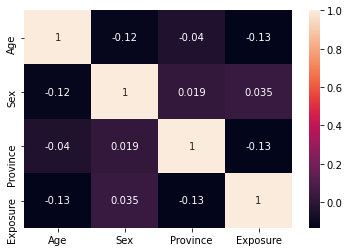

In [258]:
# coorelation matric for data
corr_mat = PatientInfo[["Age","Sex","Province","Exposure"]].corr()
sns.heatmap(corr_mat, annot = True)

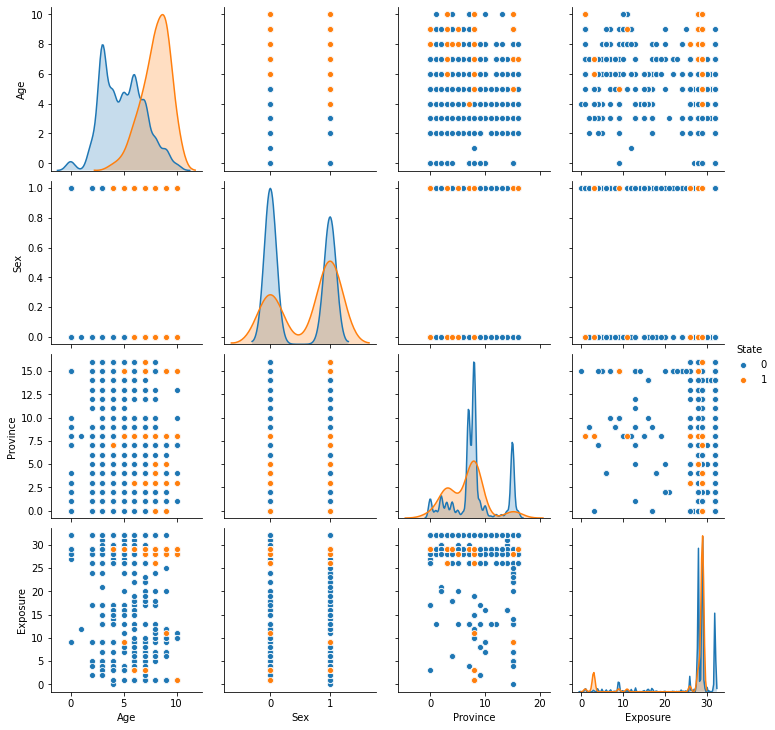

In [259]:
# Pairplot for to find classification pattern 
sns.pairplot(PatientInfo[["Age","Sex","Province","Exposure","State"]], hue='State', size=2.5)

In [260]:
dataInput = PatientInfo[["Age","Sex","Province","Exposure"]]
dataOutput = PatientInfo[["State"]]

In [261]:
Deaths = np.sum(PatientInfo.State[(PatientInfo.State == 1)])
Safe = len(PatientInfo.State) - Deaths
print("Percentage of death in data :: " ,np.round((Deaths/len(PatientInfo.State))*100,2))
print("Percentage of Safe cases in data :: ", np.round((Safe/len(PatientInfo.State))*100,2))

Percentage of death in data ::  1.98
Percentage of Safe cases in data ::  98.02


## Pre-Processing Data

In [262]:
#genarting splitter for shuffling and splitting dataset
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.20, train_size=None) 
#generating indices for splitting the input data into test and train data
train_index, test_index = next(rs.split(dataInput))
 #generating indices for further splitting train data into validation and train data
train_index, val_index = next(rs.split(train_index))

In [263]:
dataInput = np.array(dataInput)
dataOutput = np.array(dataOutput)

In [264]:
trainX = dataInput[train_index]
trainy = dataOutput[train_index]
valX = dataInput[val_index]
valy = dataOutput[val_index]
testX = dataInput[test_index]
testy = dataOutput[test_index]

In [269]:
print("Shape of original Input training data :: ",trainX.shape," Shape of original Output training data :: ",trainy.shape)
print("Counts of label 1 :: ",sum(trainy == 1)," Counts of label 0 :: ",sum(trainy == 0))

Shape of original Input training data ::  (2420, 4)  Shape of original Output training data ::  (2420, 1)
Counts of label 1 ::  [46]  Counts of label 0 ::  [2374]


#### Oversampling training data to eliminate data imbalance

In [270]:
sm = SMOTE(random_state = 2) 
trainXSM, trainySM = sm.fit_sample(trainX, trainy.ravel())
trainySM = trainySM.reshape((-1,1))

In [271]:
print("Shape of SMOTE Input training data :: ",trainXSM.shape," Shape of SMOTE Output training data :: ",trainySM.shape)
print("Counts of label 1 :: ",sum(trainySM == 1)," Counts of label 0 :: ",sum(trainySM == 0))

Shape of SMOTE Input training data ::  (4748, 4)  Shape of SMOTE Output training data ::  (4748, 1)
Counts of label 1 ::  [2374]  Counts of label 0 ::  [2374]


In [272]:
ad = ADASYN(random_state = 2) 
trainXADA, trainyADA = ad.fit_sample(trainX, trainy.ravel())
trainyADA = trainyADA.reshape((-1,1))

In [273]:
print("Shape of ADASYN Input training data :: ",trainXADA.shape," Shape of ADASYN Output training data :: ",trainyADA.shape)
print("Counts of label 1 :: ",sum(trainyADA == 1)," Counts of label 0 :: ",sum(trainyADA == 0))

Shape of ADASYN Input training data ::  (4744, 4)  Shape of ADASYN Output training data ::  (4744, 1)
Counts of label 1 ::  [2370]  Counts of label 0 ::  [2374]


In [274]:
#now we normalize the data in Age, Sex, Province and Exposure column
trainXSM = (trainXSM - np.mean(trainXSM,axis=0))/np.std(trainXSM,axis=0)
trainXADA = (trainXADA - np.mean(trainXADA,axis=0))/np.std(trainXADA,axis=0)
valX = (valX - np.mean(valX,axis=0))/np.std(valX,axis=0)
testX = (testX - np.mean(testX,axis=0))/np.std(testX,axis=0)

In [275]:
trainXSM = np.column_stack((np.ones((len(trainXSM),1)),trainXSM))
trainXADA = np.column_stack((np.ones((len(trainXADA),1)),trainXADA))
valX = np.column_stack((np.ones((len(valX),1)),valX))
testX = np.column_stack((np.ones((len(testX),1)),testX))

### Logistic Regression with SMOTE

In [276]:
#defining the sigmoid function (1-dimensional)
def sigf(var):
    return np.exp(var)/(1 + np.exp(var))

#defining sigmoid function which applies to a vector: returns nx1 vector
def sigmoidf(w,X):
    Xw = np.dot(X,w)
    yhat = np.apply_along_axis(sigf, 1, Xw)
    return yhat

#defining custom function to compute loss/cost: returns scalar
def loss(w,X,y):
    yhat = sigmoidf(w,X)
    N = len(y)
    lvalue = ((-1 / N) * np.sum((y * np.log(yhat)) + ((1 -y)* np.log(1-yhat))))
    return lvalue

#defining custom function to compute gradient of cost function: returns 3x1 vector
def gradient(w,X,y):
    yhat = sigmoidf(w,X)
    N = len(y)
    gradient = ((-1 / N) * np.dot(X.T,(y - yhat)))
    return gradient

#defining custom function to generate batches of data for SGD. using a subset of full dataset for each step of gradient descent
def minibatchSGD(X,y,batchSize):
    initialpoint = np.random.randint(0, X.shape[0] - batchSize - 1) 
    Xbatch = X[initialpoint:(initialpoint + batchSize)] 
    ybatch = y[initialpoint:(initialpoint + batchSize)]
    return Xbatch,ybatch

#predicting output (i.e. state) once parameters are estimated. we use user given threshold to classify prediction as a 1 or 0
def predit(w,X,threshold):
    prediction = sigmoidf(w,X)
    prediction[prediction>=threshold] = 1
    prediction[prediction<threshold] = 0
    return prediction.astype(int)

#defining custom function to calculate accuracy of our predictor
def accuracy(predicted, actual):
    return np.round((sum(predicted==actual)/len(predicted))*100,2)[0] #checking which entries have predict == actual and then adding 1 to numarator for each such case

#generating confusion matrix based on actual and predicted values of state
def generateConfusionMatrix(predicted,actual):
    confusionMatrix = np.zeros((2,2),dtype = int)
    for i in range(len(predicted)):
        confusionMatrix[ actual[i][0] ][ predicted[i][0] ] += 1
    confusionMatrix = pd.DataFrame(confusionMatrix,columns=["predicted_Safe","predicted_Death"],
                index=["Safe","Death"])
    return confusionMatrix

#defining custom function to implement polyak's momentum method for gradient desccent
def polyakMomentum (y,X,w,alpha,beta,thrs,bsize,maxi,val_y,val_X): 
    converged =  False
    i = 1
    w1 = w
    z = np.zeros((len(w),1))
    previousValLoss = 0
    #SGD means stochastic gradient descent
    #perform SGD until we converge or max number of iterations are crossed
    while(((not converged)  and (i <= maxi))):
            batchX,batchy = minibatchSGD(X,y,bsize)
            deltafx = gradient(w1,batchX,batchy)
            if (np.isinf(deltafx).any() or np.isnan(deltafx).any() or np.isnan(np.linalg.norm(deltafx,2))):
                break
            # polyakMomentum 
            z = beta*z + deltafx
            w1 = w1 - (alpha*z)
            valLoss = loss(w1,val_X,val_y)
            converged = np.abs(previousValLoss - valLoss) < thrs*previousValLoss
            previousValLoss = valLoss
            i = i+1
    return w1,previousValLoss, converged

def datamatrixlr(coeffs_with_thres):
    matArray = np.zeros((2,5))
    for index,coeff_w_th in enumerate(coeffs_with_thres):
        matArray[index][0] = sm.accuracy_score(testy,predit(coeff_w_th[0],testX, coeff_w_th[1]))
        matArray[index][1] = sm.precision_score(testy,predit(coeff_w_th[0],testX, coeff_w_th[1]))
        matArray[index][2] = sm.recall_score(testy,predit(coeff_w_th[0],testX, coeff_w_th[1]))
        matArray[index][3] = sm.f1_score(testy,predit(coeff_w_th[0],testX, coeff_w_th[1]))
        matArray[index][4] = sm.roc_auc_score(testy,predit(coeff_w_th[0],testX, coeff_w_th[1]))
    return matArray




In [277]:
bsize = 100 #taking batch size of 100 for each step of SGD
maxi = 1000 #taking maximum no. of iterations to be 1000
thrs = 0.001 #assuming threshold of 0.001 as convergence criteria
alphas = [0.1,1,10] #assuming three different step sizes
betas = [0.3,0.5,0.7] #assuming three different betas for polyaks method
coeffs = list()
Valloss = list()
params = list()
for alpha in alphas:
    for beta in betas:
        w = np.reshape(np.random.normal(0, 1/5, 5),(5,1))
        coeff,valLoss, converged =polyakMomentum(trainySM,trainXSM,w,alpha,beta,thrs,bsize,maxi,valy,valX)
        if converged:
            coeffs.append(coeff)
            Valloss.append(valLoss)
            params.append((alpha,beta))

In [278]:
#finding which alpha+beta combination works best at minimizing cost of the predictor
coeffSMOTE = coeffs[np.where(Valloss == min(Valloss))[0][0]]
alpha,beta = params[np.where(Valloss == min(Valloss))[0][0]]

In [279]:
print("Coefficients :: ",coeffSMOTE.reshape((1,5)))
print("alpha :: ",alpha,"beta :: ",beta)

Coefficients ::  [[-0.30367335  1.20326821  0.13047773 -0.39128594  0.20454699]]
alpha ::  1 beta ::  0.5


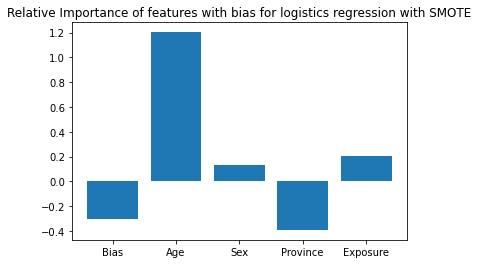

In [400]:
barPlot1 = plt.bar(["Bias","Age","Sex","Province","Exposure"],coeffSMOTE.reshape((1,5))[0])
title = plt.title("Relative Importance of features with bias for logistics regression with SMOTE")

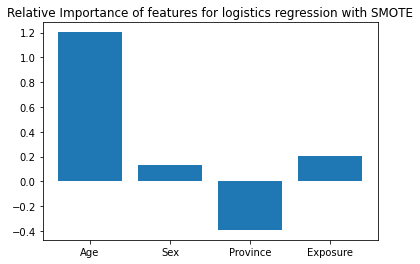

In [401]:
barPlot = plt.bar(["Age","Sex","Province","Exposure"],coeffSMOTE.reshape((1,5))[:,1:5][0])
title = plt.title("Relative Importance of features for logistics regression with SMOTE")

In [282]:
#we will consider three different thresholds for classifying data as either 0 or 1
for thres in [0.5,0.7,0.8, 0.9]:
    print("Confusion Matrix and Accuracy for thresold :: ",thres)
    print()
    print(generateConfusionMatrix(predit(coeffSMOTE,testX,thres),testy))
    print("Accuracy :: ", accuracy(predit(coeffSMOTE,testX,thres),testy))
    print()

Confusion Matrix and Accuracy for thresold ::  0.5

       predicted_Safe  predicted_Death
Safe              449              298
Death               3                7
Accuracy ::  60.24

Confusion Matrix and Accuracy for thresold ::  0.7

       predicted_Safe  predicted_Death
Safe              582              165
Death               5                5
Accuracy ::  77.54

Confusion Matrix and Accuracy for thresold ::  0.8

       predicted_Safe  predicted_Death
Safe              669               78
Death               5                5
Accuracy ::  89.04

Confusion Matrix and Accuracy for thresold ::  0.9

       predicted_Safe  predicted_Death
Safe              732               15
Death               7                3
Accuracy ::  97.09



In [405]:
dataI = pd.DataFrame(testX,columns=["Intercept","Age","Sex","Province","Exposure"]).join(pd.DataFrame(testy,columns=["State"]))

In [406]:
z = lambda x,y: (-coeffSMOTE[0][0]-coeffSMOTE[1][0]*x -coeffSMOTE[2][0]*y) / coeffSMOTE[3][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

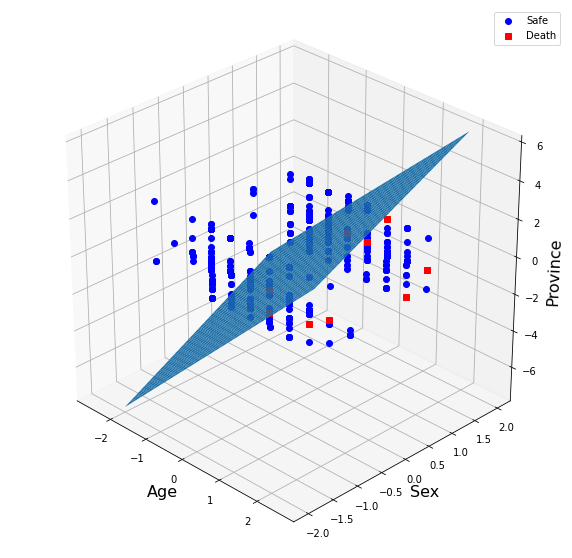

In [410]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==0], dataI.Sex[dataI.State==0], dataI.Province[dataI.State==0],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Province[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Province', fontsize=16)
ax.view_init(30, -45)
lengend = ax.legend()
plt.show()

In [286]:
z = lambda x,y: (-coeffSMOTE[0][0]-coeffSMOTE[1][0]*x -coeffSMOTE[2][0]*y) / coeffSMOTE[4][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

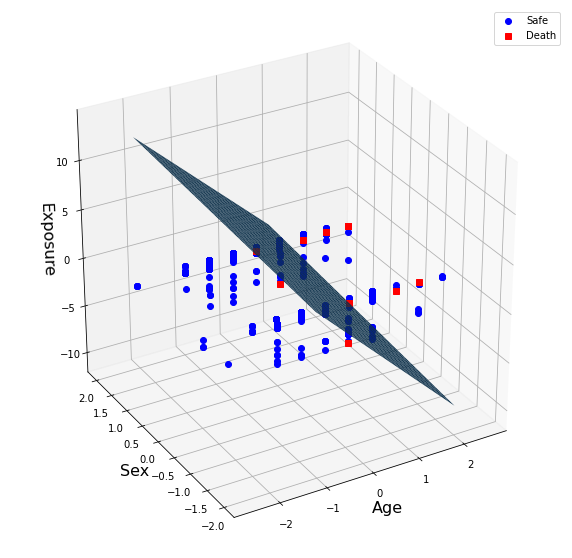

In [287]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==0], dataI.Sex[dataI.State==0], dataI.Exposure[dataI.State==0],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Exposure[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Exposure', fontsize=16)
ax.view_init(30, -120)
lengend = ax.legend()
plt.show()

### Logistic Regression with ADASYN

In [289]:
bsize = 100 #taking batch size of 100 for each step of SGD
maxi = 1000 #taking maximum no. of iterations to be 1000
thrs = 0.001 #assuming threshold of 0.001 as convergence criteria
alphas = [0.1,1,10] #assuming three different step sizes
betas = [0.3,0.5,0.7] #assuming three different betas for polyaks method
coeffs = list()
Valloss = list()
params = list()
for alpha in alphas:
    for beta in betas:
        w = np.reshape(np.random.normal(0, 1/5, 5),(5,1))
        coeff,valLoss, converged =polyakMomentum(trainyADA,trainXADA,w,alpha,beta,thrs,bsize,maxi,valy,valX)
        if converged:
            coeffs.append(coeff)
            Valloss.append(valLoss)
            params.append((alpha,beta))

In [290]:
#finding which alpha+beta combination works best at minimizing cost of the predictor
coeffADASYN = coeffs[np.where(Valloss == min(Valloss))[0][0]]
alpha,beta = params[np.where(Valloss == min(Valloss))[0][0]]

In [291]:
print("Coefficients :: ",coeffADASYN.reshape((1,5)))
print("alpha :: ",alpha,"beta :: ",beta)

Coefficients ::  [[-0.20028121  1.03550176  0.39436222 -0.4584064  -0.03127389]]
alpha ::  0.1 beta ::  0.5


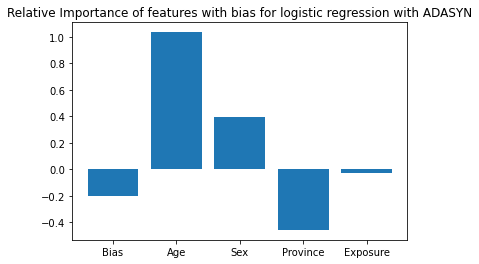

In [402]:
barPlot = plt.bar(["Bias","Age","Sex","Province","Exposure"],coeffADASYN.reshape((1,5))[0])
title = plt.title("Relative Importance of features with bias for logistic regression with ADASYN")

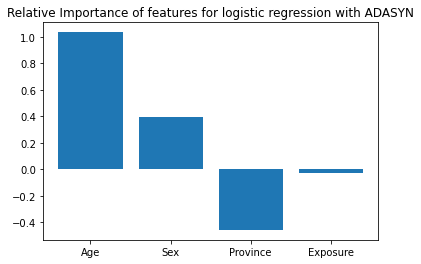

In [403]:
barPlot = plt.bar(["Age","Sex","Province","Exposure"],coeffADASYN.reshape((1,5))[:,1:5][0])
title = plt.title("Relative Importance of features for logistic regression with ADASYN")

In [294]:
#we will consider three different thresholds for classifying data as either 0 or 1
for thres in [0.4, 0.5, 0.6, 0.7,0.8,0.9]:
    print("Confusion Matrix and Accuracy for thresold :: ",thres)
    print()
    print(generateConfusionMatrix(predit(coeffADASYN,testX,thres),testy))
    print("Accuracy :: ", accuracy(predit(coeffADASYN,testX,thres),testy))
    print()

Confusion Matrix and Accuracy for thresold ::  0.4

       predicted_Safe  predicted_Death
Safe              338              409
Death               0               10
Accuracy ::  45.97

Confusion Matrix and Accuracy for thresold ::  0.5

       predicted_Safe  predicted_Death
Safe              412              335
Death               0               10
Accuracy ::  55.75

Confusion Matrix and Accuracy for thresold ::  0.6

       predicted_Safe  predicted_Death
Safe              517              230
Death               2                8
Accuracy ::  69.35

Confusion Matrix and Accuracy for thresold ::  0.7

       predicted_Safe  predicted_Death
Safe              605              142
Death               4                6
Accuracy ::  80.71

Confusion Matrix and Accuracy for thresold ::  0.8

       predicted_Safe  predicted_Death
Safe              673               74
Death               5                5
Accuracy ::  89.56

Confusion Matrix and Accuracy for thresold ::  0.9

   

In [295]:
dataI = pd.DataFrame(testX,columns=["Intercept","Age","Sex","Province","Exposure"]).join(pd.DataFrame(testy,columns=["State"]))

In [296]:
z = lambda x,y: (-coeffADASYN[0][0]-coeffADASYN[1][0]*x -coeffADASYN[2][0]*y) / coeffADASYN[3][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

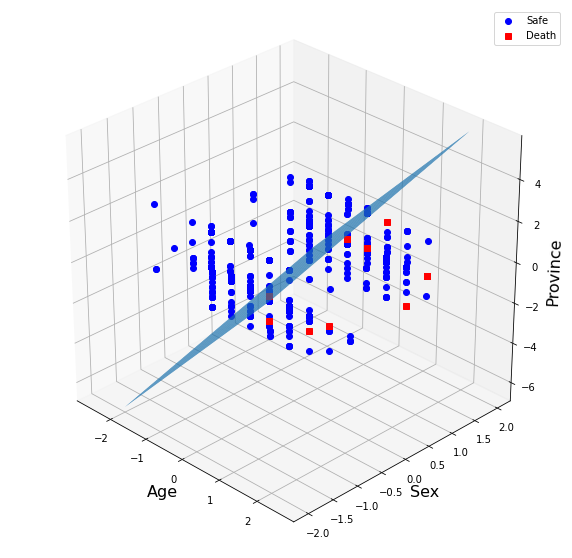

In [298]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==0], dataI.Sex[dataI.State==0], dataI.Province[dataI.State==0],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Province[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Province', fontsize=16)
ax.view_init(30, -45)
lengend = ax.legend()
plt.show()

In [299]:
z = lambda x,y: (-coeffADASYN[0][0]-coeffADASYN[1][0]*x -coeffADASYN[2][0]*y) / coeffADASYN[4][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

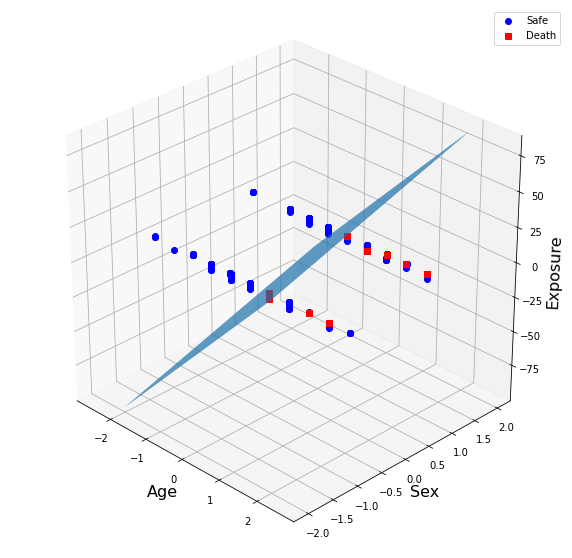

In [301]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==0], dataI.Sex[dataI.State==0], dataI.Exposure[dataI.State==0],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Exposure[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Exposure', fontsize=16)
ax.view_init(30, -45)
lengend = ax.legend()
plt.show()

## SVM

In [302]:
#defining custom function to implement the sub gradient function: returns a scalar
def g(t):
    if (t < 1):
        return (-1)
    else:
        return (0)

#defining custom function to compute tn: returns a nx1 vector
def tn(y, w, X):
    t = y * np.dot(X,w)
    return (t)

#compute loss as terminating condition
def svmloss(w,C,X,y):
    N  = len(X)
    distances = 1 - y * np.dot(X,w)
    distances[distances < 0] = 0 # equivalent to max(0, distance)
    hinge_loss = C * (sum(distances) / N)
    # calculate cost
    cost = 1 / 2 * np.dot(w.T,w) + hinge_loss
    return cost

#defining custom function to return gradient of cost function in SVM
def svmgradient(w,C,X,y):
    deltaF = np.zeros((X.shape[1],1))
    summ =  np.zeros((X.shape[1],1))
    for n in range(len(y)):
        t = tn(y[n],w,X[n])
        gn = g(t)
        diff = w + (C * gn * y[n] * X[n]).reshape((X.shape[1],1))
        summ = summ + diff
    deltaF = summ/len(y)
    return (deltaF)

#defining custom function to implement polyak's momentum method for gradient desccent
def gradientDescentSvm (y,X,w,alpha,C,thrs,bsize,maxi,val_y,val_X): 
    converged =  False
    i = 1
    w1 = w
    z = np.zeros((len(w),1))
    previousValLoss = 0
    #SGD means stochastic gradient descent
    #perform SGD until we converge or max number of iterations are crossed
    while(((not converged)  and (i <= maxi))):
            batchX,batchy = minibatchSGD(X,y,bsize)
            deltafx = svmgradient(w1,C,batchX,batchy)
            if (np.isinf(deltafx).any() or np.isnan(deltafx).any() or np.isnan(np.linalg.norm(deltafx,2))):
                break
            w1 = w1 - (alpha*deltafx)
            valLoss = svmloss(w1,C,X,y)
            converged = np.abs(previousValLoss - valLoss) < thrs*previousValLoss
            previousValLoss = valLoss
            i = i+1
    return w1,previousValLoss, converged

def predictSvm(X,w):
    yhat  = np.dot(X,w)
    yhat[yhat < 0] = -1
    yhat[yhat > 0] = 1
    return yhat.astype(int)

def accuarcySvm(predicted, actual):
    return np.round((sum(predicted==actual)/len(predicted))*100,2)[0]

def generateConfusionMatrixSvm(predicted,actual):
    confusionMatrix = np.zeros((2,2),dtype = int)
    for index in range(len(predicted)):
        i,j = 1,1
        if (actual[index][0] == -1):
           i = 0 
        if (predicted[index][0] == -1):
           j = 0 
        confusionMatrix[ i ][ j ] += 1
    confusionMatrix = pd.DataFrame(confusionMatrix,columns=["predicted_Safe","predicted_Death"],
                index=["Safe","Death"])
    return confusionMatrix

def datamatrixSVM(coeffs):
    matArray = np.zeros((2,5))
    for index,coeff in enumerate(coeffs):
        matArray[index][0] = sm.accuracy_score(testySVM,predictSvm(testX, coeff))
        matArray[index][1] = sm.precision_score(testySVM,predictSvm(testX, coeff))
        matArray[index][2] = sm.recall_score(testySVM,predictSvm(testX, coeff))
        matArray[index][3] = sm.f1_score(testySVM,predictSvm(testX, coeff))
        matArray[index][4] = sm.roc_auc_score(testySVM,predictSvm(testX, coeff))
    return matArray

### SVM with SMOTE

In [319]:
#we will first prepare test, validation and training outputs i.e. the y's. we will change output to 0 where it is -1
trainySVMSM = trainySM
trainySVMSM[trainySVMSM==1] = 1
trainySVMSM[trainySVMSM==0] = -1
valySVM = cp.copy(valy)
valySVM[valy==1] = 1
valySVM[valy==0] = -1
testySVM = cp.copy(testy)
testySVM[testy==1] = 1
testySVM[testy==0] = -1

In [320]:
bsize = 100 #taking batch size of 100 for each step of SGD
maxi = 1000 #taking maximum no. of iterations to be 1000
thrs = 0.01 #assuming threshold of 0.001 as convergence criteria
alphas = [0.1,1,10] #assuming three different step sizes
tradeoff = [1, 50, 100]
coeffs = list()
Valloss = list()
params = list()
for C in tradeoff:
    for alpha in alphas:
        w = np.reshape(np.random.normal(0, 1/5, 5),(5,1))
        coeff,valLoss, converged = gradientDescentSvm(trainySVMSM,trainXSM,w,alpha,C,thrs,bsize,maxi,valySVM,valX)
        if converged:
            coeffs.append(coeff)
            Valloss.append(valLoss)
            params.append((alpha,C))

In [326]:
# Accuracy and confusion matrix for all models
for index, param in enumerate(params):
    print("Confusion Matrix and Accuracy for alpha :: ",param[0]," and C :: ", param[1])
    print()
    print(generateConfusionMatrixSvm(predictSvm(testX, coeffs[index]),testySVM))
    print("Accuracy :: ", accuarcySvm(predictSvm(testX, coeffs[index]),testySVM))
    print()

Confusion Matrix and Accuracy for alpha ::  0.1  and C ::  1

       predicted_Safe  predicted_Death
Safe              450              297
Death               1                9
Accuracy ::  60.63

Confusion Matrix and Accuracy for alpha ::  1  and C ::  1

       predicted_Safe  predicted_Death
Safe               66              681
Death               0               10
Accuracy ::  10.04

Confusion Matrix and Accuracy for alpha ::  0.1  and C ::  50

       predicted_Safe  predicted_Death
Safe              348              399
Death               0               10
Accuracy ::  47.29

Confusion Matrix and Accuracy for alpha ::  1  and C ::  50

       predicted_Safe  predicted_Death
Safe              725               22
Death              10                0
Accuracy ::  95.77

Confusion Matrix and Accuracy for alpha ::  0.1  and C ::  100

       predicted_Safe  predicted_Death
Safe              633              114
Death               5                5
Accuracy ::  84.28

Confu

In [327]:
#Based on confusion matrix above we selected cofficients
coeffSVMSM = coeffs[4]
alpha,C = params[4]

In [330]:
print("Coefficients :: ",coeffSVMSM.reshape((1,5)))
print("alpha :: ",alpha,"C :: ",C)

Coefficients ::  [[-3.9235946   3.46114972  0.47746701 -0.61682599  0.66490752]]
alpha ::  0.1 C ::  100


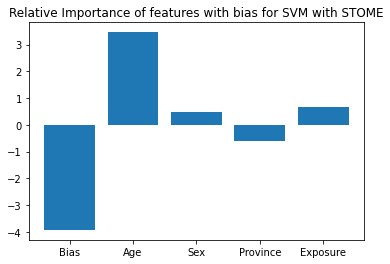

In [423]:
barPlot = plt.bar(["Bias","Age","Sex","Province","Exposure"],coeffSVMSM.reshape((1,5))[0])
title = plt.title("Relative Importance of features with bias for SVM with STOME")

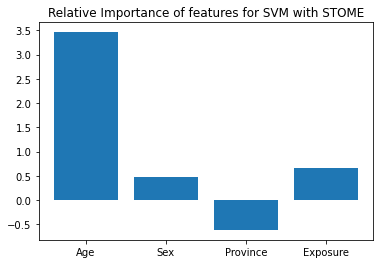

In [422]:
barPlot = plt.bar(["Age","Sex","Province","Exposure"],coeffSVMSM.reshape((1,5))[:,1:5][0])
title = plt.title("Relative Importance of features for SVM with STOME")

In [337]:
dataI = pd.DataFrame(testX,columns=["Intercept","Age","Sex","Province","Exposure"]).join(pd.DataFrame(testySVM,columns=["State"]))

In [338]:
z = lambda x,y: (-coeffSVMSM[0][0]-coeffSVMSM[1][0]*x -coeffSVMSM[2][0]*y) / coeffSVMSM[3][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

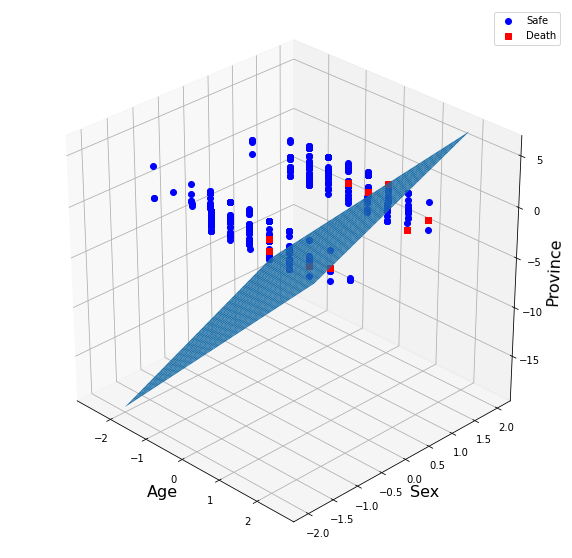

In [341]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==-1], dataI.Sex[dataI.State==-1], dataI.Province[dataI.State==-1],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Province[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Province', fontsize=16)
ax.view_init(30, -45)
lengend = ax.legend()
plt.show()

In [342]:
z = lambda x,y: (-coeffSVMSM[0][0]-coeffSVMSM[1][0]*x -coeffSVMSM[2][0]*y) / coeffSVMSM[3][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

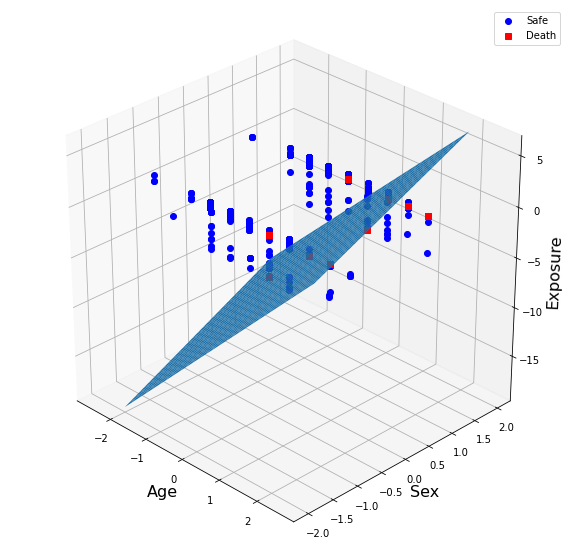

In [343]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==-1], dataI.Sex[dataI.State==-1], dataI.Exposure[dataI.State==-1],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Exposure[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Exposure', fontsize=16)
ax.view_init(30, -45)
lengend = ax.legend()
plt.show()

### SVM with ADASYN

In [344]:
#we will first prepare test, validation and training outputs i.e. the y's. we will change output to 0 where it is -1
trainySVMADA = trainyADA
trainySVMADA[trainySVMADA==1] = 1
trainySVMADA[trainySVMADA==0] = -1
valySVM = cp.copy(valy)
valySVM[valy==1] = 1
valySVM[valy==0] = -1
testySVM = cp.copy(testy)
testySVM[testy==1] = 1
testySVM[testy==0] = -1

In [347]:
bsize = 100 #taking batch size of 100 for each step of SGD
maxi = 1000 #taking maximum no. of iterations to be 1000
thrs = 0.01 #assuming threshold of 0.001 as convergence criteria
alphas = [0.1,1,10] #assuming three different step sizes
tradeoff = [1, 50, 100]
coeffs = list()
Valloss = list()
params = list()
for C in tradeoff:
    for alpha in alphas:
        w = np.reshape(np.random.normal(0, 1/5, 5),(5,1))
        coeff,valLoss, converged = gradientDescentSvm(trainySVMADA,trainXADA,w,alpha,C,thrs,bsize,maxi,valySVM,valX)
        if converged:
            coeffs.append(coeff)
            Valloss.append(valLoss)
            params.append((alpha,C))

In [348]:
# Accuracy and confusion matrix for all models
for index, param in enumerate(params):
    print("Confusion Matrix and Accuracy for alpha :: ",param[0]," and C :: ", param[1])
    print()
    print(generateConfusionMatrixSvm(predictSvm(testX, coeffs[index]),testySVM))
    print("Accuracy :: ", accuarcySvm(predictSvm(testX, coeffs[index]),testySVM))
    print()

Confusion Matrix and Accuracy for alpha ::  0.1  and C ::  1

       predicted_Safe  predicted_Death
Safe              424              323
Death               2                8
Accuracy ::  57.07

Confusion Matrix and Accuracy for alpha ::  1  and C ::  1

       predicted_Safe  predicted_Death
Safe              668               79
Death               5                5
Accuracy ::  88.9

Confusion Matrix and Accuracy for alpha ::  0.1  and C ::  50

       predicted_Safe  predicted_Death
Safe              747                0
Death              10                0
Accuracy ::  98.68

Confusion Matrix and Accuracy for alpha ::  1  and C ::  50

       predicted_Safe  predicted_Death
Safe              672               75
Death               6                4
Accuracy ::  89.3

Confusion Matrix and Accuracy for alpha ::  0.1  and C ::  100

       predicted_Safe  predicted_Death
Safe              535              212
Death               4                6
Accuracy ::  71.47

Confusi

In [351]:
#Based on confusion matrix above we select cofficients
coeffSVMADA = coeffs[3]
alpha,C = params[3]

In [352]:
print("Coefficients :: ",coeffSVMADA.reshape((1,5)))
print("alpha :: ",alpha,"C :: ",C)

Coefficients ::  [[-33.          15.81454332 -11.43225799 -16.53567717  -0.23580007]]
alpha ::  1 C ::  50


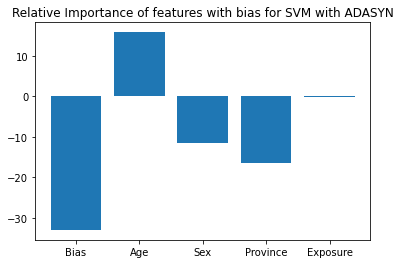

In [424]:
barPlot = plt.bar(["Bias","Age","Sex","Province","Exposure"],coeffSVMADA.reshape((1,5))[0])
title = plt.title("Relative Importance of features with bias for SVM with ADASYN")

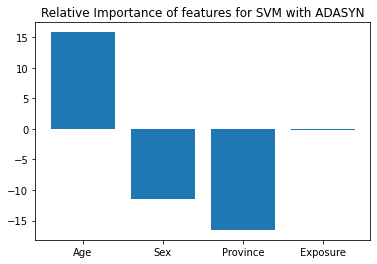

In [425]:
barPlot = plt.bar(["Age","Sex","Province","Exposure"],coeffSVMADA.reshape((1,5))[:,1:5][0])
title = plt.title("Relative Importance of features for SVM with ADASYN")

In [355]:
dataI = pd.DataFrame(testX,columns=["Intercept","Age","Sex","Province","Exposure"]).join(pd.DataFrame(testySVM,columns=["State"]))

In [356]:
z = lambda x,y: (-coeffSVMADA[0][0]-coeffSVMADA[1][0]*x -coeffSVMADA[2][0]*y) / coeffSVMADA[3][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

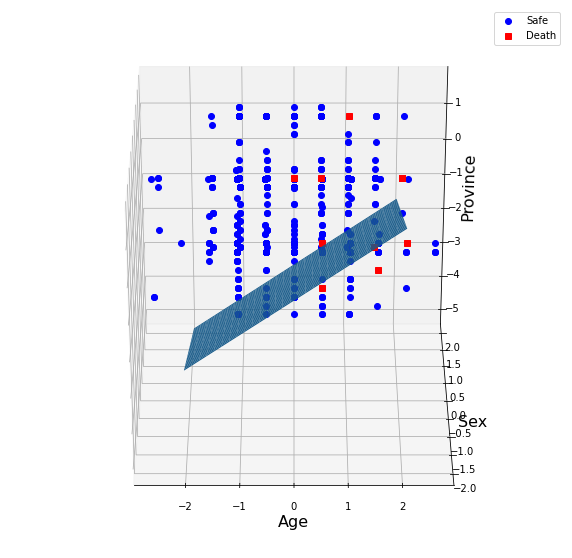

In [359]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==-1], dataI.Sex[dataI.State==-1], dataI.Province[dataI.State==-1],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Province[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Province', fontsize=16)
ax.view_init(30, -90)
lengend = ax.legend()
plt.show()

In [360]:
z = lambda x,y: (-coeffSVMADA[0][0]-coeffSVMADA[1][0]*x -coeffSVMADA[2][0]*y) / coeffSVMADA[3][0]
tmpx = np.linspace(-2,2,30)
tmpy = np.linspace(-2,2,30)
x,y = np.meshgrid(tmpx,tmpy)

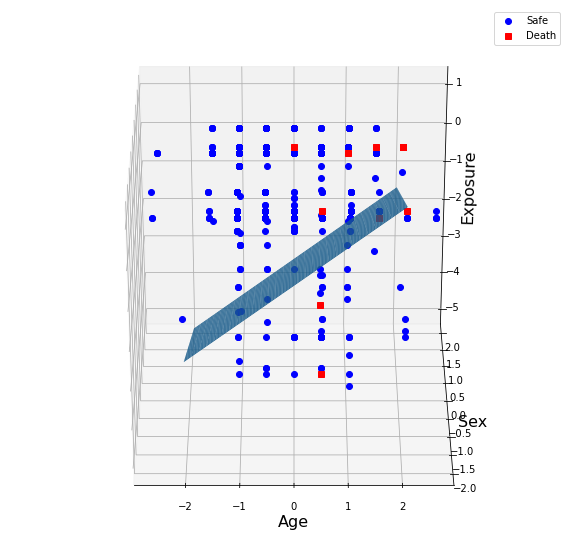

In [362]:
fig = plt.figure(figsize=(10,10))
ax  = fig.add_subplot(111, projection='3d')
safeplot = ax.plot3D(dataI.Age[dataI.State==-1], dataI.Sex[dataI.State==-1], dataI.Exposure[dataI.State==-1],'ob',label='Safe')
deathplot = ax.plot3D(dataI.Age[dataI.State==1], dataI.Sex[dataI.State==1], dataI.Exposure[dataI.State==1],'sr',label='Death')
plane = ax.plot_surface(x, y, z(x,y))
xLabel = ax.set_xlabel('Age', fontsize=16)
yLabel = ax.set_ylabel('Sex', fontsize=16)
zLabel = ax.set_zlabel('Exposure', fontsize=16)
ax.view_init(30, -90)
lengend = ax.legend()
plt.show()

## Creating Metrics data for all the models

In [395]:
coeffs = [coeffSVMSM,coeffSVMADA]
svm_metrics = datamatrixSVM(coeffs)
# threshold is decided on the basis of confusion matrix plotted above
coeffsth = [(coeffSMOTE,0.9),(coeffADASYN,0.9)]
lr_metrics = datamatrixlr(coeffsth)
metrics_data = pd.DataFrame(np.row_stack((lr_metrics,svm_metrics)),
                                         columns=["Accuracy","Precision","Recall","F1","ROC_AUC_SCORE"],
                                        index = ["Logistic regression (SMOTE)", "Logistic regression (ADASYN)"
                                                ,"SVM (SMOTE)", "SVM (ADASYN)"])

## Insights from Data

There is not much correlation in features.\
There is class imbalance in data. Number of deaths ( represented by 1 ) is way less than Number of safe cases (represented by 0). \
From pair plot we can see that classification is possible as for many pairs of features we can draw classification line but there are some features pairs for which classification if difficult if not impossible for example (Sex and Exposure), (Sex and Province).

## Data Visualization

To visualize classifiers we decided to plot data in three dimension (taking three features at a time). For each model we ploted classifier in 3 dimension for two combination ("Age","Sex","Province","Exposure") and ("Age","Sex","Exposure").we can see from all the plots classifing plane in for best model configurations are very satisfactory. All the classifiers are able classify data succsessfully.

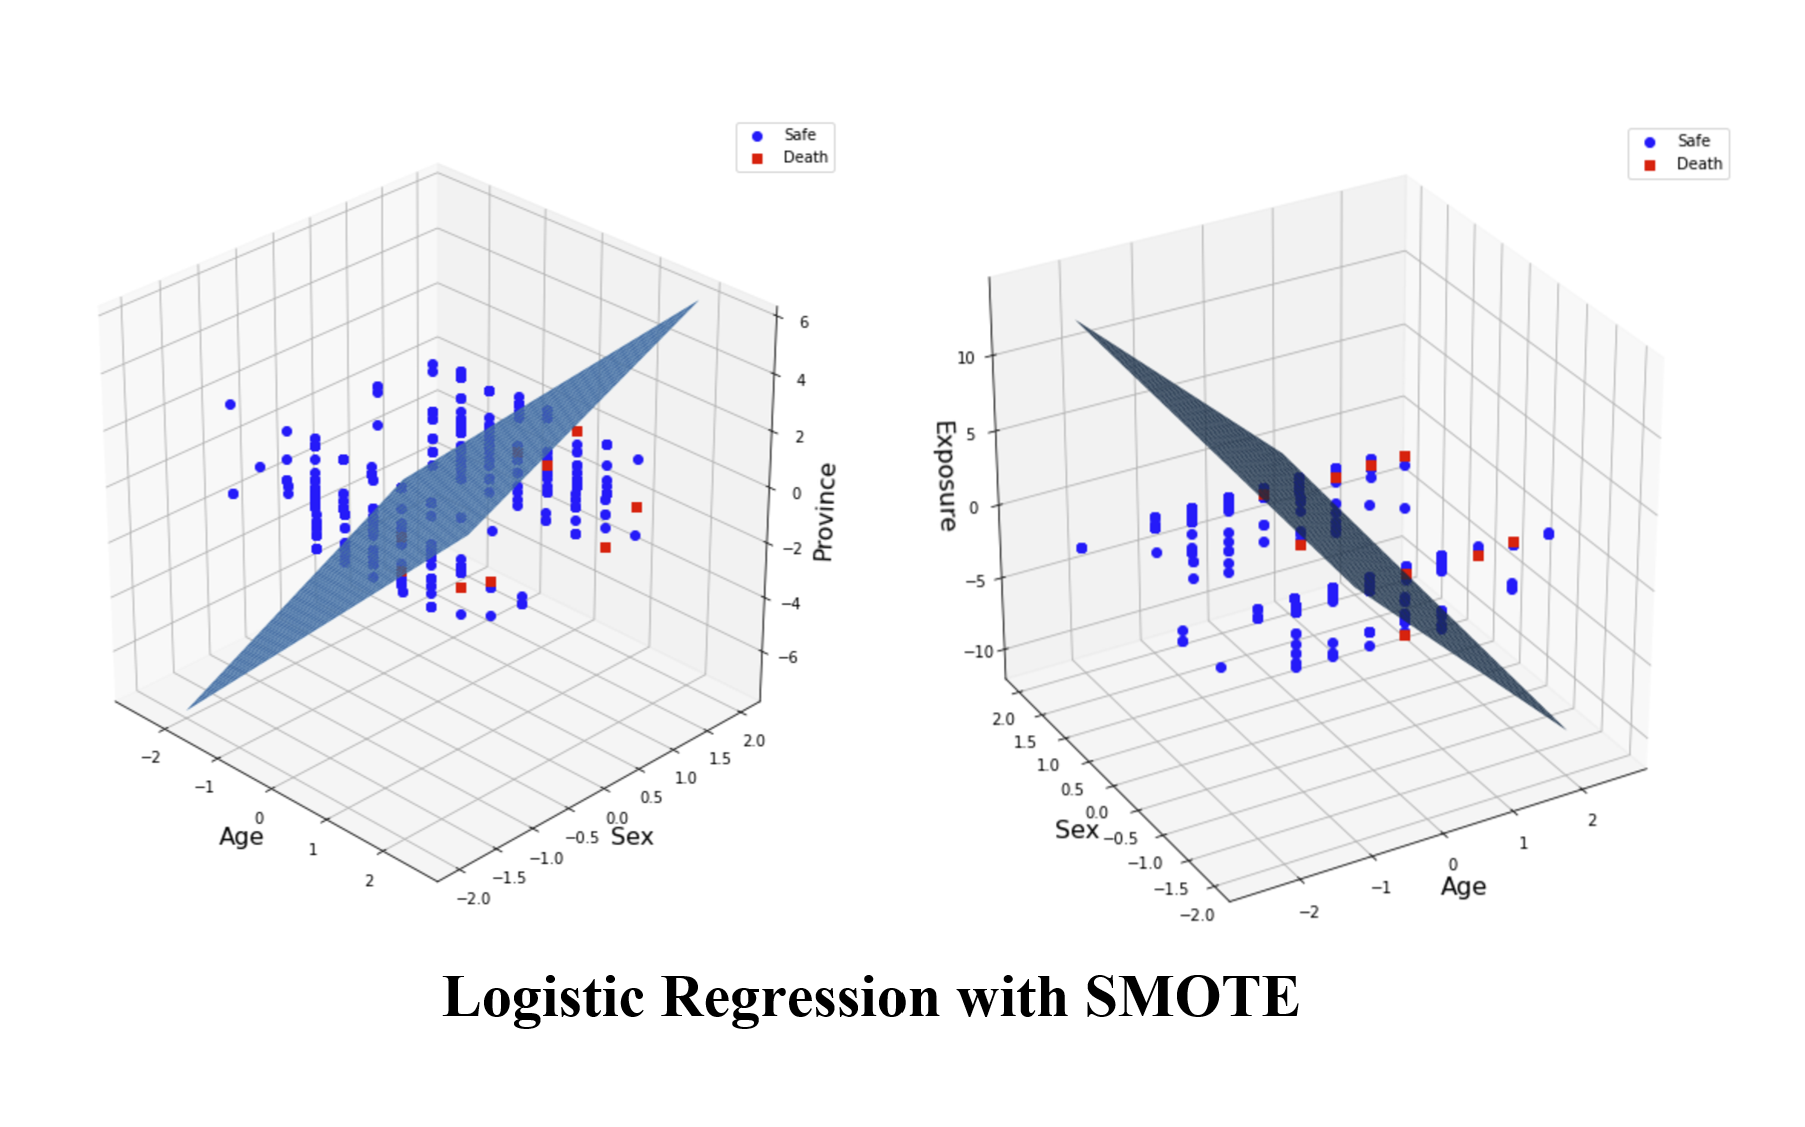

In [429]:
Image("image1.png", width=800, height=800)

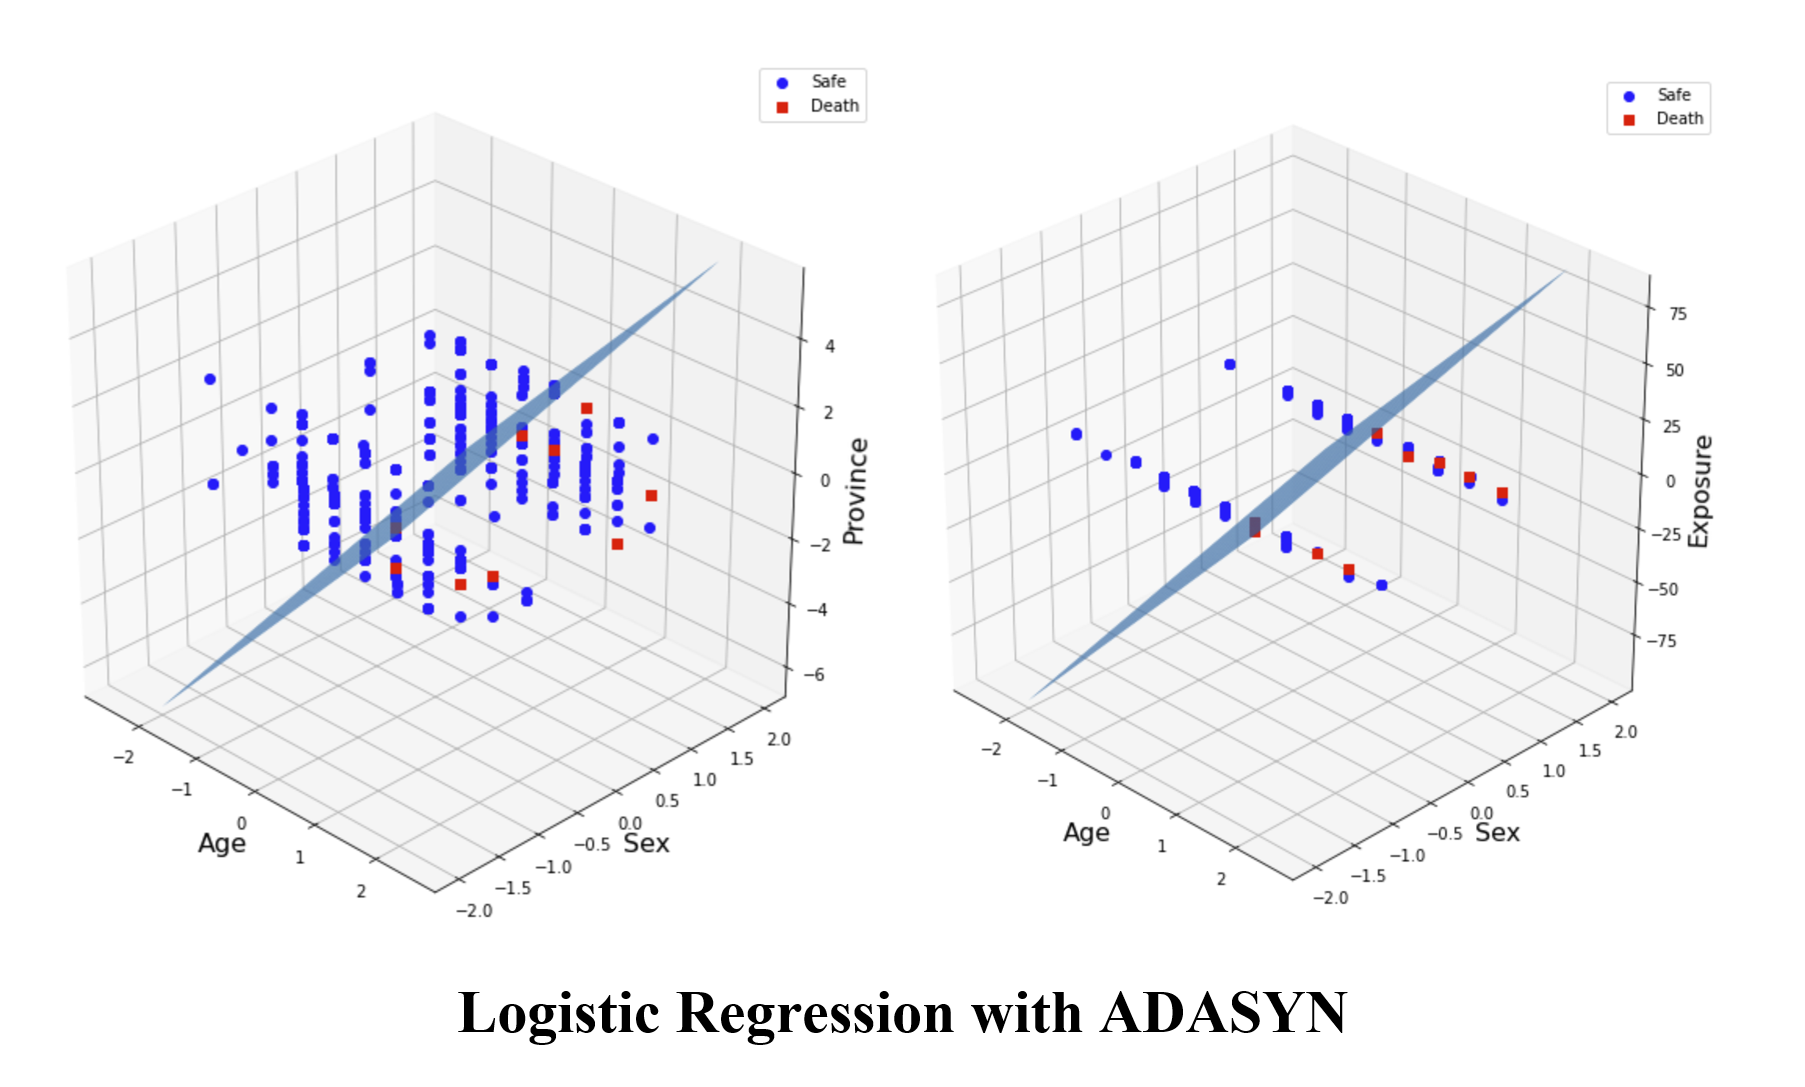

In [430]:
Image("image2.png", width=800, height=800)

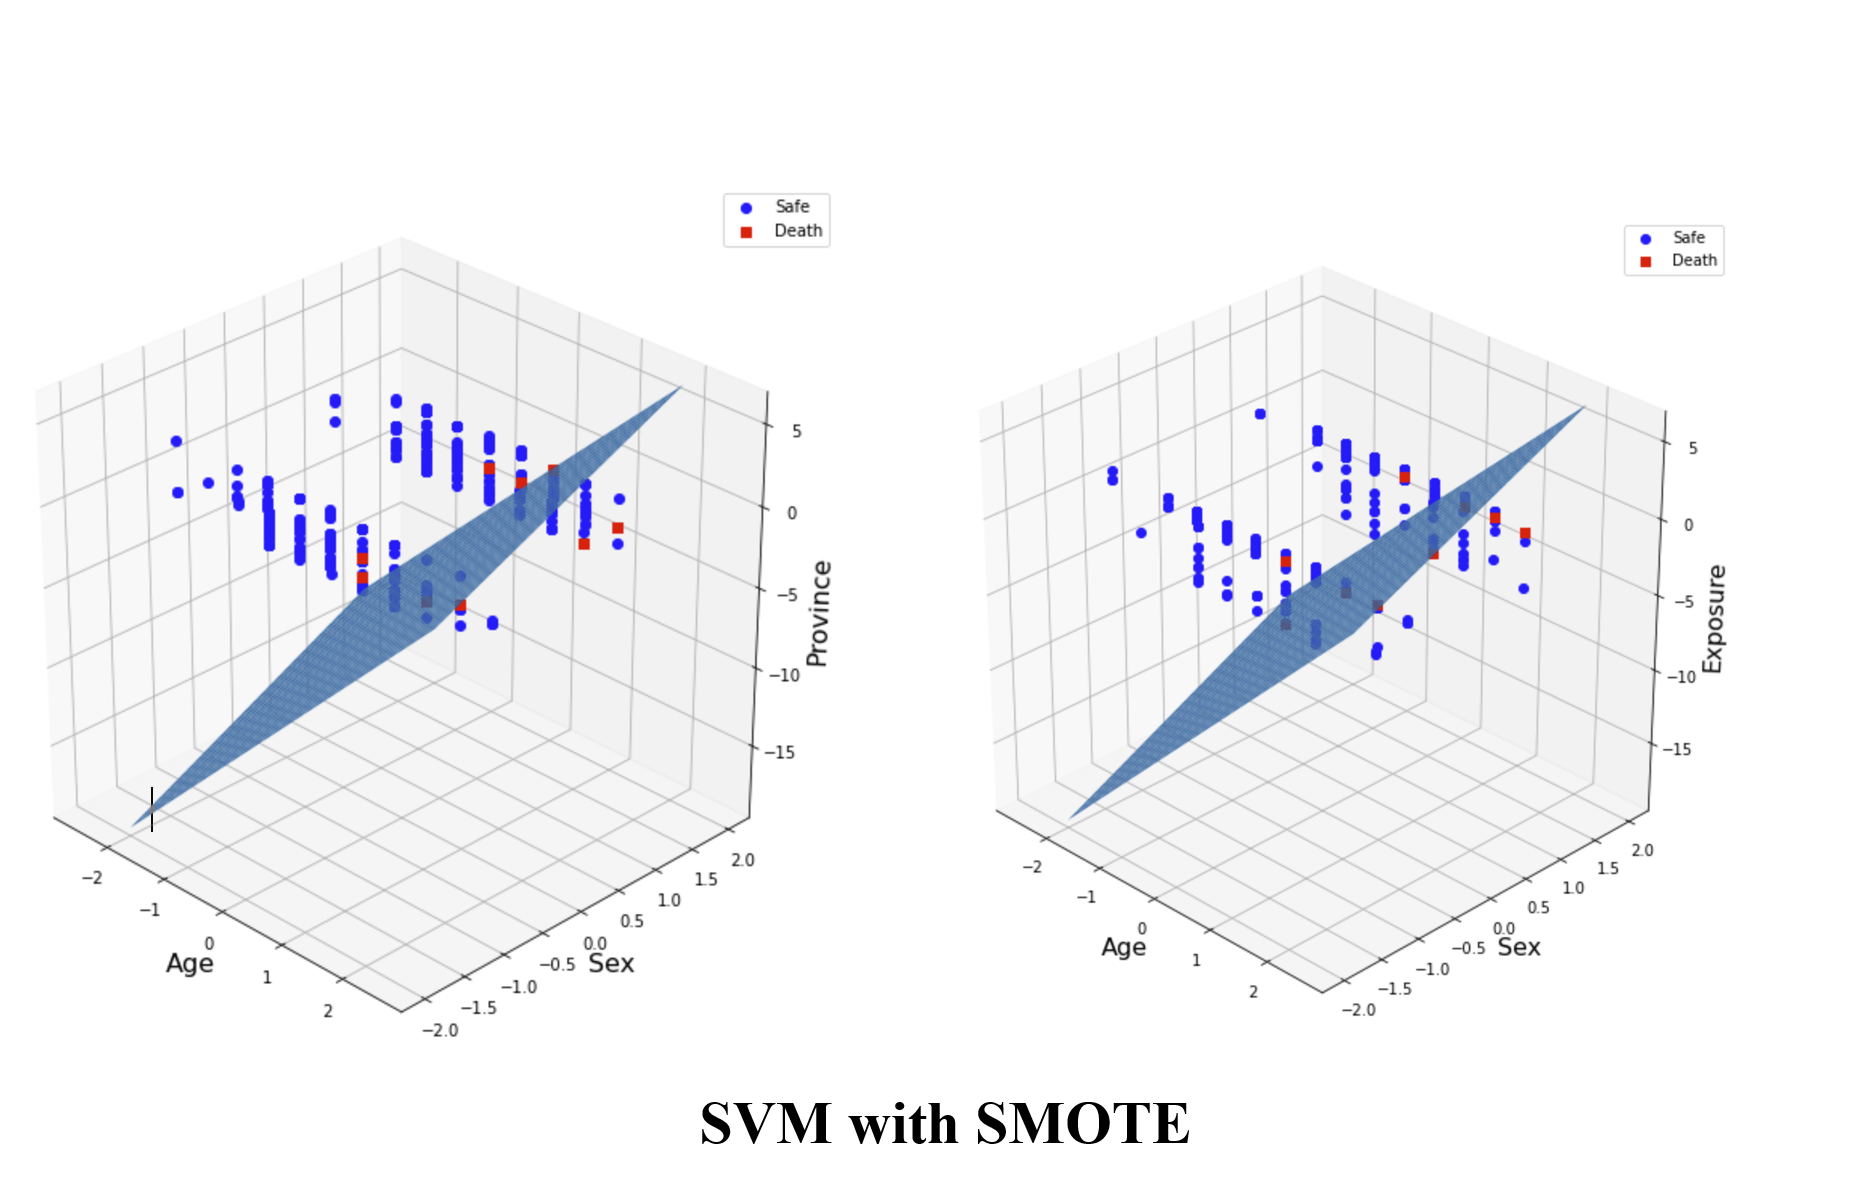

In [431]:
Image("image3.png", width=800, height=800)

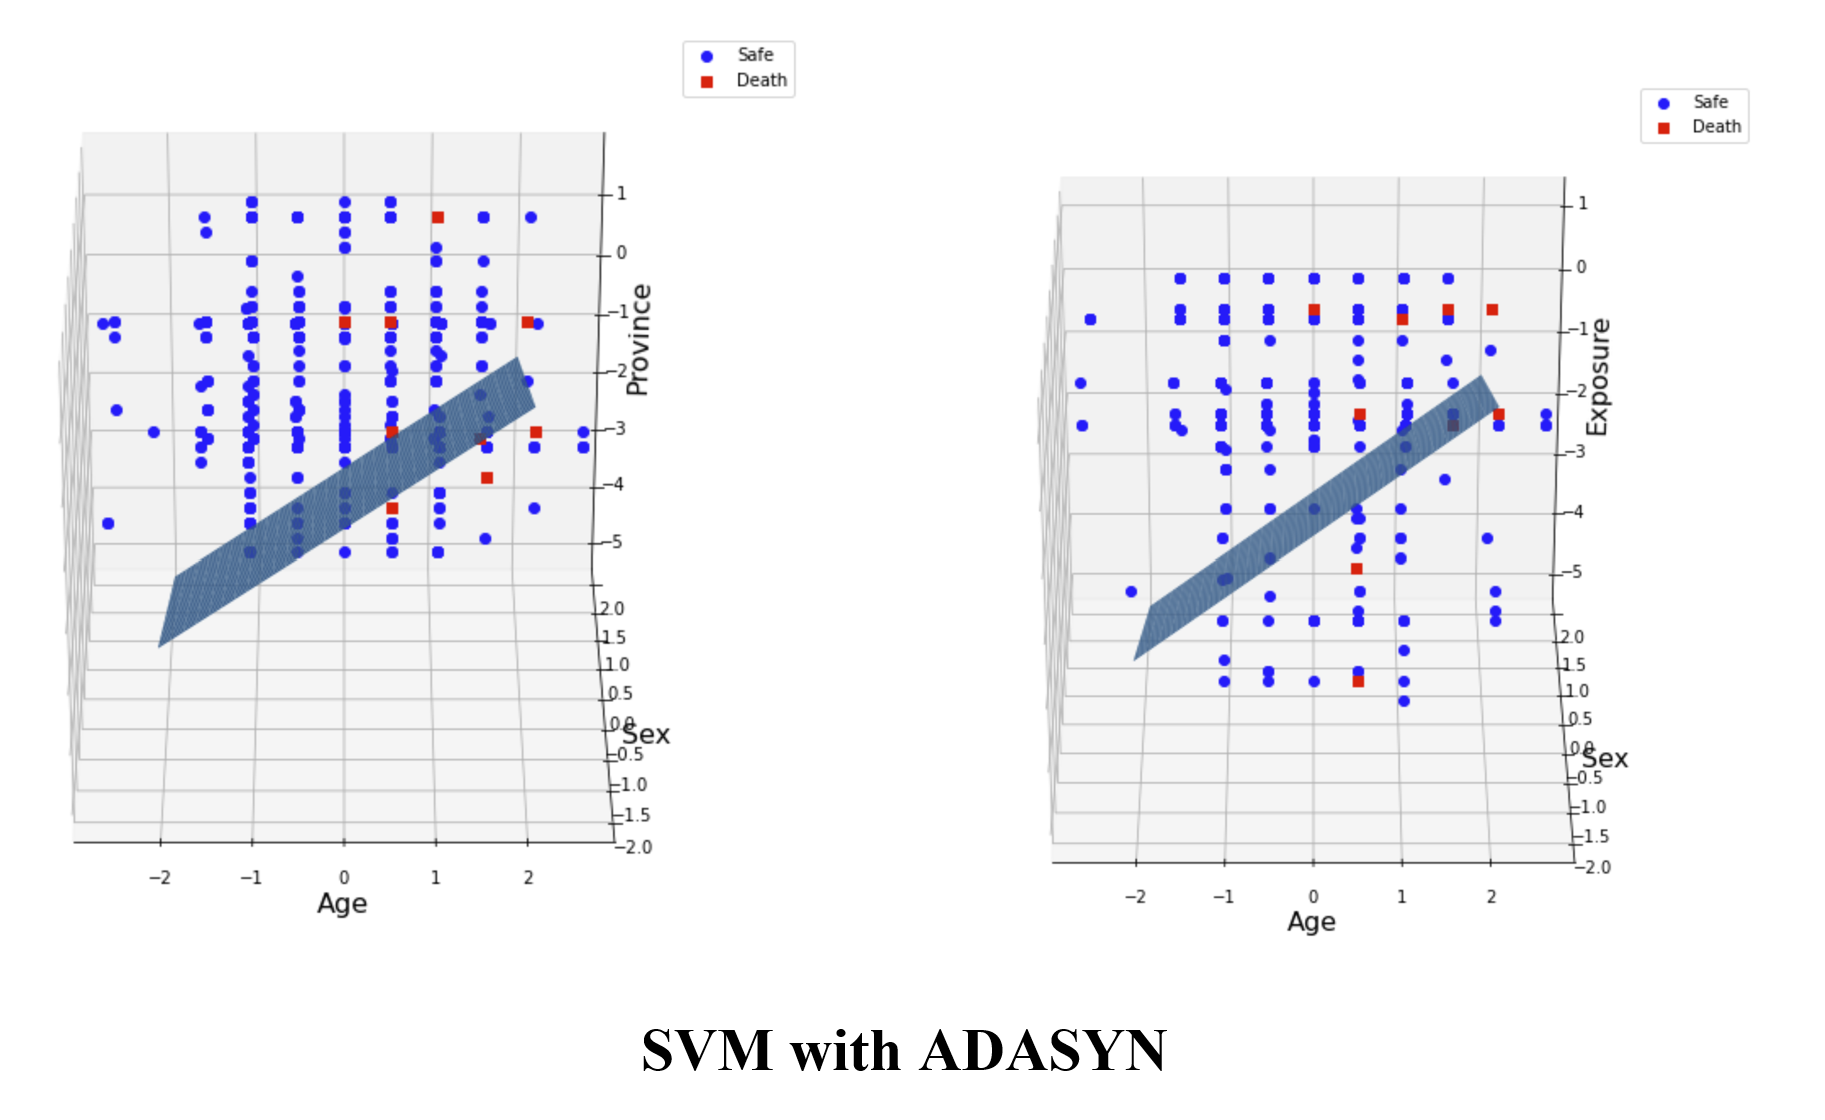

In [432]:
Image("image4.png", width=800, height=800)

## Inference based on cofficient values.

Since we have standarize data before modelling, we can draw inference about relative importance of features from cofficient values for each model.\

**For Linear Regression Age with STOME, Age > Exposure > Sex (in order) pulls output to 1 while Province pulls outputs to 0.**\
**For Linear Regression Age with ADASYN, Age > Sex> Exposure  (in order) pulls output to 1 while Province pulls outputs to 0.**\
**For SVM with STOME Age > Exposure > Sex (in order) pulls output to 1 while Province pulls outputs to -1(0).**\
**For SVM with ADASYN and Age pulls output to 1 while Sex > Province > Exposure (in order) pulls outputs to -1(0).**

These inference are not strict but give a close idea.

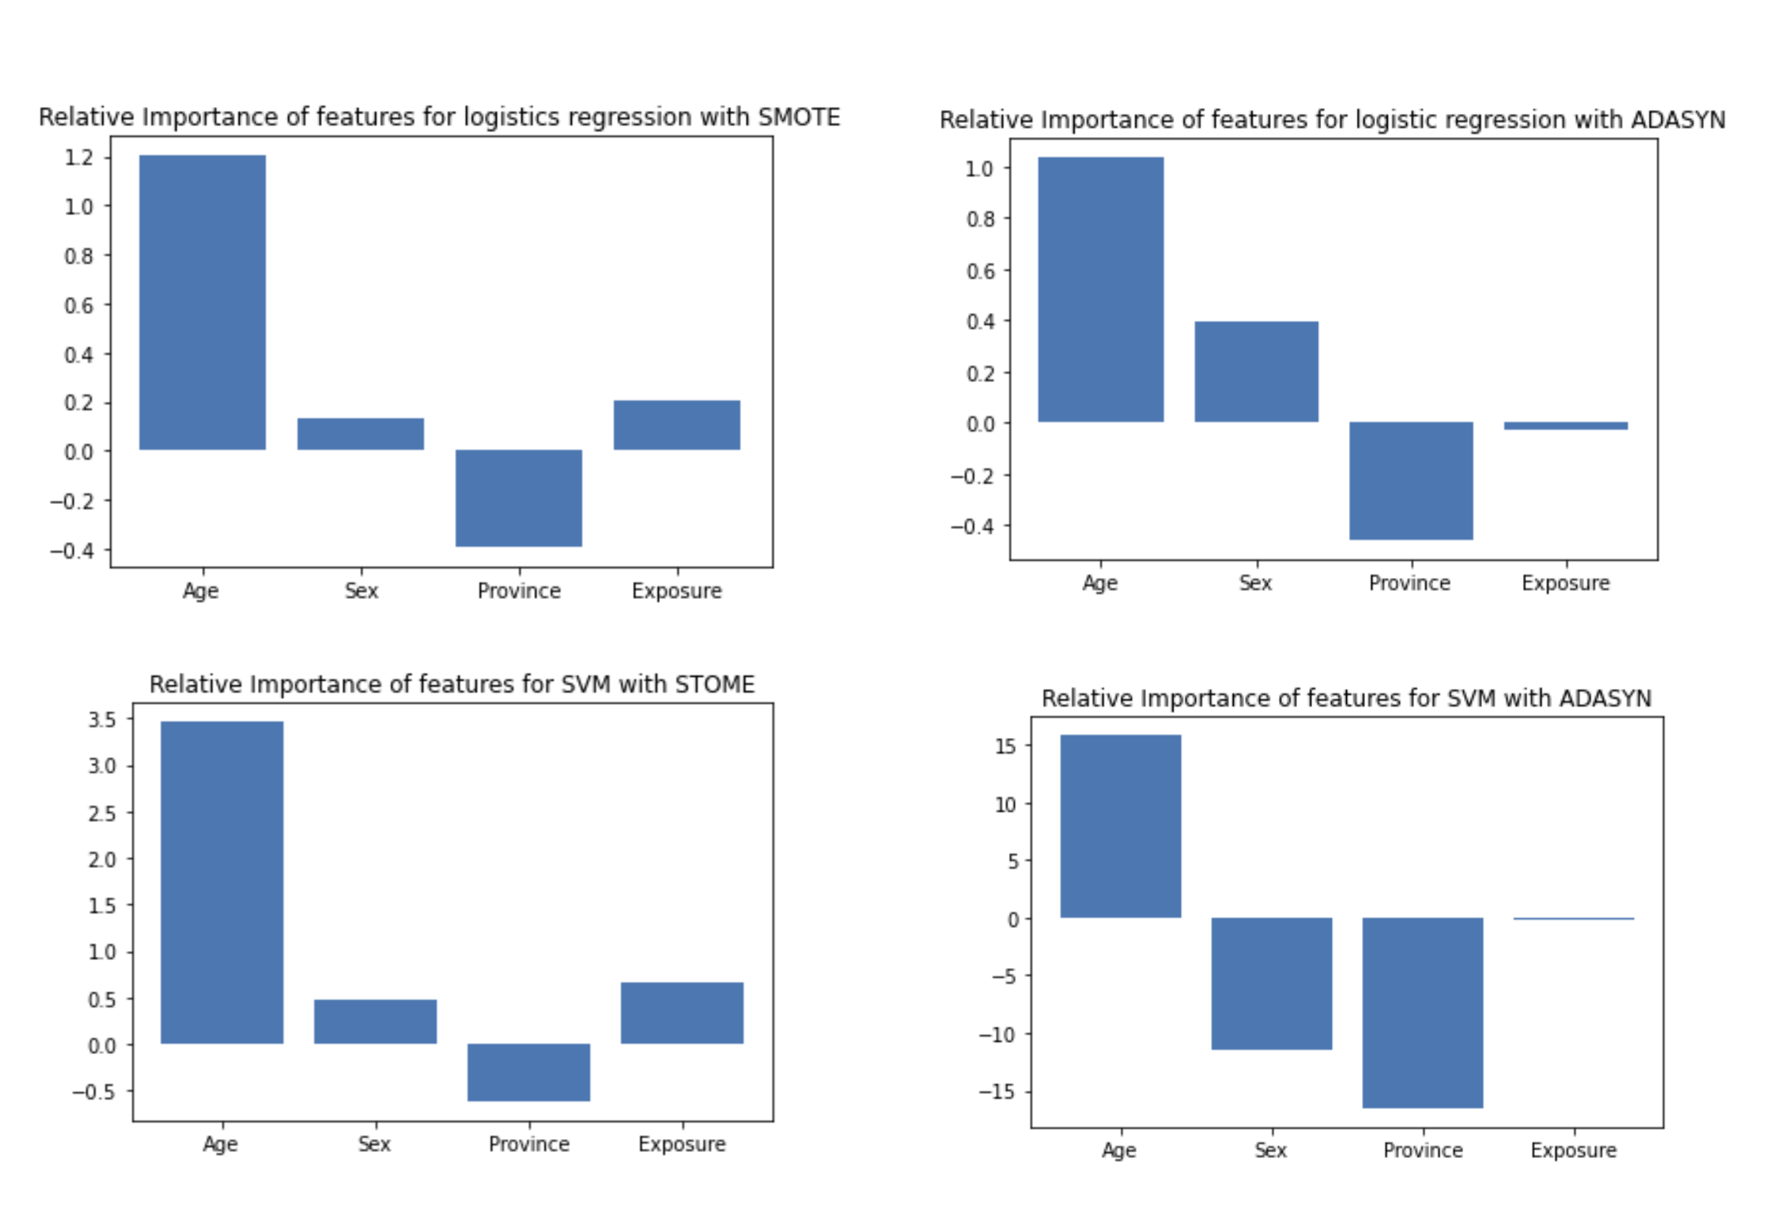

In [433]:
Image("image5.png", width=800, height=800)

In [428]:
display(metrics_data)

,Accuracy,Precision,Recall,F1,ROC_AUC_SCORE
Logistic regression (SMOTE),0.970938,0.166667,0.3,0.214286,0.639960
Logistic regression (ADASYN),0.968296,0.150000,0.3,0.200000,0.638621
SVM (SMOTE),0.842801,0.042017,0.5,0.077519,0.673695
SVM (ADASYN),0.892999,0.050633,0.4,0.089888,0.649799


## Inference based metrics data.

Metrics table above we can compare two models for various parameters and decide with one is best.\

**In terms of over all accuracy Logistic regression is better.**\
**In terms F1 score and Precision Logistic regression is way better then SVM.**\
**In terms of ROC_AUC_SCORE and Recall SVM is better but the difference is small.**

Thus logistic regression correctly predict the if person will survive or not better than SVM.(The above values are most best models of each type)

Github link for the code 

https://github.com/jainsanyam786/OptimizationForMachineLearning.git